In [1]:
%matplotlib notebook

import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.random
from tabulate import tabulate ## conda install tabulate
from sortedcontainers import SortedSet ## conda install sortedcontainers
from collections import OrderedDict
from functools import reduce
import numpy.random
import codecs
import itertools
import functools
import pickle
import pycrfsuite # conda install -c conda-forge pycrfsuite
from sklearn.metrics import classification_report

inNotebook = True # change this to True if you use a notebook
def nextplot():
    if inNotebook:
        plt.figure()  # this creates a new plot
    else:
        plt.clf()     # and this clears the current one

In [2]:
# After loading this file, try "help(Var)", "help(Dist)", "help(Factor)", and
# "help(FactorGraph)". You can also have a look at this file for additional
# details, although this shouldn't be necessary.
%run -i "graphical-models-helper.py"

# API examples

In [3]:
# We are using the Dist object to represent a joint distribution over a set of
# variables. We usually won't create such a distribution directly, but this
# example shows you how to do so anyway. The example is the Hayfever/Flu
# distribution from the lecture slides.
#
# we first create the variables
Hayfever = Var('Hayfever', 2) ## 2 = two possible values = binary
Flu = Var('Flu', 2)
print('Name =', Hayfever.name, '; domain size =', Hayfever.K, '; value =', Hayfever.value)
print(Hayfever)

Name = Hayfever ; domain size = 2 ; value = 0
Hayfever=0


In [4]:
# and then the distribution
dist = Dist([Hayfever, Flu], np.array([[.2, .4], [.35, .05]]))
print(dist)

  Hayfever    Flu    value
----------  -----  -------
         0      0     0.2
         0      1     0.4
         1      0     0.35
         1      1     0.05


In [5]:
# a distribution consists of a list of variables (vars) and an array holding the
# joint probabilities (values)
print([ var.name for var in dist.vars ])
print(dist.values)
print(dist.values[1,0]) # probability that var0=1 (Hayfever) and var1=0 (Flu)

['Hayfever', 'Flu']
[[ 0.2   0.4 ]
 [ 0.35  0.05]]
0.35


In [6]:
# We can determine the probability associated with the current values for all variables.
print(Hayfever, Flu)
print(dist.value())

Hayfever=0 Flu=0
0.2


In [7]:
# We can sample from a distribution; the result is another `Dist`, but this time
# it holds sample frequencies (i.e., it's not normalized). There is a function
# to normalize as well.
print( dist.sample(100) )
print( dist.sample(100).normalize() )

  Hayfever    Flu    value
----------  -----  -------
         0      0       24
         0      1       33
         1      0       38
         1      1        5
  Hayfever    Flu    value
----------  -----  -------
         0      0     0.22
         0      1     0.46
         1      0     0.3
         1      1     0.02


In [8]:
# Using the sum rule, variables can be marginalized out.
print(dist.marginalize(Hayfever))
print(dist.marginalize(Flu))

  Flu    value
-----  -------
    0     0.55
    1     0.45
  Hayfever    value
----------  -------
         0      0.6
         1      0.4


In [9]:
# Finally, we can fix a value of a variable. Here we compute the
# joint P(Hayfever, Flu=1), then the conditional P(Hayfever | Flu=1)
print( dist.fix(Flu, 1) )
print( dist.fix(Flu, 1).normalize() )

  Hayfever    value
----------  -------
         0     0.4
         1     0.05
  Hayfever     value
----------  --------
         0  0.888889
         1  0.111111


In [10]:
# Create variables of misconception example
A = Var('Anna', 2)
B = Var('Bob', 2)
C = Var('Charlie', 2)
D = Var('Debbie', 2)

In [11]:
# Create factors for misconception example. Factors are also `Dist`s, i.e., they
# have the same functionality as illustrated above.
phi1 = Factor([A,B])
phi2 = Factor([B,C])
phi3 = Factor([C,D])
phi4 = Factor([D,A])
phi1.values[:] = [[30,5],[1,10]]
phi2.values[:] = [[100,1],[1,100]]
phi3.values[:] = [[1,100],[100,1]]
phi4.values[:] = [[100,1],[1,100]]
print(phi1)

  Anna    Bob    value
------  -----  -------
     0      0       30
     0      1        5
     1      0        1
     1      1       10


In [12]:
# But we can also compute factor products.
phi12 = phi1*phi2
print(phi12)

  Anna    Bob    Charlie    value
------  -----  ---------  -------
     0      0          0     3000
     0      0          1       30
     0      1          0        5
     0      1          1      500
     1      0          0      100
     1      0          1        1
     1      1          0       10
     1      1          1     1000


In [13]:
# Create factor graph for misconception example.
Gm = FactorGraph()
Gm.add_vars([A,B,C,D])
Gm.add_factors([phi1,phi2,phi3,phi4])
print(Gm)

FactorGraph (4 variables, 4 factors)


In [14]:
# Access the data. (Use these only to read, change using the API illustrated
# above and below.)
print([ var.name for var in Gm.vars ])
print( Gm.factors )
print( Gm.factors_for[A] )
print( Gm.value() )

['Anna', 'Bob', 'Charlie', 'Debbie']
{<__main__.Factor object at 0x2b89ab4e3518>, <__main__.Factor object at 0x2b89ab4e34a8>, <__main__.Factor object at 0x2b89ab4e3550>, <__main__.Factor object at 0x2b89ab4e3470>}
{<__main__.Factor object at 0x2b89ab4e3550>, <__main__.Factor object at 0x2b89ab4e3470>}
300000.0


In [15]:
# Copy and modify factor graphs
G = Gm.copy() # G shares variables and factors with Gm, but not the "structure"
A.value = B.value = C.value = D.value = 1
G.add_factor(phi12)
print(G, G.value())
G.remove_factors([phi1, phi2])
print(G, G.value())
G.remove_var(D) # removes associated factors, too
print(G, G.value())

FactorGraph (4 variables, 5 factors) 100000000.0
FactorGraph (4 variables, 3 factors) 100000.0
FactorGraph (3 variables, 1 factors) 1000.0


# 1 Inference in Factor Graphs

## 1a Naive

In [16]:
def naive(G):
    """Perform naive inference on the given factor graph `G`.

    Returns
    -------
    a ``Dist`` object for the joint distribution represented by the factor graph
    """
    # YOUR CODE HERE
    return Factor.normalize(functools.reduce(lambda x, y: x * y, G.factors))

In [17]:
# test your solution; this should give (as in the lecture)
#   Anna    Bob    Charlie    Debbie        value
# ------  -----  ---------  --------  -----------
#      0      0          0         0  0.041656
#      0      0          0         1  0.041656
#      0      0          1         0  0.041656
#      0      0          1         1  4.1656e-06
#      0      1          0         0  6.94267e-05
#      0      1          0         1  6.94267e-05
#      0      1          1         0  0.694267
#      0      1          1         1  6.94267e-05
#      1      0          0         0  1.38853e-05
#      1      0          0         1  0.138853
#      1      0          1         0  1.38853e-05
#      1      0          1         1  1.38853e-05
#      1      1          0         0  1.38853e-06
#      1      1          0         1  0.0138853
#      1      1          1         0  0.0138853
#      1      1          1         1  0.0138853
distm = naive(Gm)
print(distm)

  Anna    Bob    Charlie    Debbie        value
------  -----  ---------  --------  -----------
     0      0          0         0  0.041656
     0      0          0         1  0.041656
     0      0          1         0  0.041656
     0      0          1         1  4.1656e-06
     0      1          0         0  6.94267e-05
     0      1          0         1  6.94267e-05
     0      1          1         0  0.694267
     0      1          1         1  6.94267e-05
     1      0          0         0  1.38853e-05
     1      0          0         1  0.138853
     1      0          1         0  1.38853e-05
     1      0          1         1  1.38853e-05
     1      1          0         0  1.38853e-06
     1      1          0         1  0.0138853
     1      1          1         0  0.0138853
     1      1          1         1  0.0138853


In [18]:
# To compare two distributions, we use L1 distance here. This is not necessarily
# the most suitable measure, but it's easy to understand: sum of absolute
# difference between corresponding probabilities.
def l1(dist1, dist2):
    if isinstance(dist1, Dist):
        return np.sum(np.abs(dist1.values - dist2.values))
    else: ## lists of marginals -> list of L1 errors
        return np.array(list(map(lambda i: np.sum(np.abs(dist1[i]-dist2[i])),
                                 range(len(dist1)))))

In [19]:
# Here is an example using independent sampling; we show the actual probability
# (p), the number of samples (n), and the relative frequency (f)
n = 10000
samplem = distm.sample(n)
freqm = samplem.normalize()
print( disttable([ distm, samplem, freqm ], ['p', 'n', 'f']) )
print( 'L1 error:', l1(distm, freqm) )

  Anna    Bob    Charlie    Debbie            p     n       f
------  -----  ---------  --------  -----------  ----  ------
     0      0          0         0  0.041656      389  0.0389
     0      0          0         1  0.041656      410  0.041
     0      0          1         0  0.041656      387  0.0387
     0      0          1         1  4.1656e-06      0  0
     0      1          0         0  6.94267e-05     2  0.0002
     0      1          0         1  6.94267e-05     1  0.0001
     0      1          1         0  0.694267     6999  0.6999
     0      1          1         1  6.94267e-05     1  0.0001
     1      0          0         0  1.38853e-05     0  0
     1      0          0         1  0.138853     1398  0.1398
     1      0          1         0  1.38853e-05     0  0
     1      0          1         1  1.38853e-05     1  0.0001
     1      1          0         0  1.38853e-06     0  0
     1      1          0         1  0.0138853     119  0.0119
     1      1          1     

## 1b Variable elimination

In [20]:
def eliminate(G, vars):
    """Return a copy of factor graph `G` in which `vars` have been eliminated."""
    Gnew = G.copy()
    if not isinstance(vars, list):
        vars = [ vars ]
    if len(vars) == 0:
        return Gnew
        
    # eliminate var from Gnew using variable elimination
    # YOUR CODE HERE
    var, *tail = vars
    factors = list(Gnew.factors_for[var])
    phi = functools.reduce(lambda x,y: x * y, factors)
    Gnew.add_factor(phi.marginalize(var))
    Gnew.remove_var(var)
    return eliminate(Gnew, tail)

In [30]:
# test it; this should give
#   Anna    Charlie    Debbie            p
# ------  ---------  --------  -----------
#      0          0         0  0.0417254
#      0          0         1  0.0417254
#      0          1         0  0.735923
#      0          1         1  7.35923e-05
#      1          0         0  1.52739e-05
#      1          0         1  0.152739
#      1          1         0  0.0138992
#      1          1         1  0.0138992
print( naive( eliminate(Gm,B) ) )

  Anna    Charlie    Debbie        value
------  ---------  --------  -----------
     0          0         0  0.0417254
     0          0         1  0.0417254
     0          1         0  0.735923
     0          1         1  7.35923e-05
     1          0         0  1.52739e-05
     1          0         1  0.152739
     1          1         0  0.0138992
     1          1         1  0.0138992


In [103]:
#   Anna         p
# ------  --------
#      0  0.819448
#      1  0.180552
print( naive( eliminate(Gm,[B,C,D]) ) )

  Anna     value
------  --------
     0  0.819448
     1  0.180552


In [70]:
# this should give the same results
print( naive(Gm).marginalize(B) )
print( naive(Gm).marginalize([B,C,D]) )

  Anna    Charlie    Debbie        value
------  ---------  --------  -----------
     0          0         0  0.0417254
     0          0         1  0.0417254
     0          1         0  0.735923
     0          1         1  7.35923e-05
     1          0         0  1.52739e-05
     1          0         1  0.152739
     1          1         0  0.0138992
     1          1         1  0.0138992
  Anna     value
------  --------
     0  0.819448
     1  0.180552


In [107]:
# Exercise 1.b

# Eliminate { A }
print( naive( eliminate(Gm,A) ) )

  Bob    Charlie    Debbie        value
-----  ---------  --------  -----------
    0          0         0  0.0416699
    0          0         1  0.180509
    0          1         0  0.0416699
    0          1         1  1.80509e-05
    1          0         0  7.08152e-05
    1          0         1  0.0139548
    1          1         0  0.708152
    1          1         1  0.0139548


In [115]:
# Eliminate { A,B }
print( naive( eliminate(Gm,[A,B]) ) )

  Charlie    Debbie      value
---------  --------  ---------
        0         0  0.0417407
        0         1  0.194464
        1         0  0.749822
        1         1  0.0139728


In [126]:
# Eliminate { A,B,C }
print( naive( eliminate(Gm,[A,B,C]) ) )

  Debbie     value
--------  --------
       0  0.791563
       1  0.208437


## 1c Gibbs Sampling

In [56]:
def gibbs(G, vars, log=False):
    """Resample the values of the variables in `vars` using Gibbs sampling.

    Variables are resampled in the order given in `vars`. For each variable, its
    value is resampled conditioned of the values of all other variables in `G`.

    If `log` is set to `True`, resampling is performed in log space for improved
    numerical stability.
    """
    for var in vars:
        ## Resample var. As before, you may use numpy.random.choice() to perform
        ## the sampling.
        # YOUR CODE HERE
        factors = G.factors_for[var]
        sample = functools.reduce(lambda x,y: x * y, factors)
        index = sample.indexOf(var)
        positions = list(map(lambda x: x.value, sample.vars))
        perc = []
        for i in range(0, var.K):
            positions[index] = i
            perc.append(sample.values[tuple(positions)])
        var.value = np.random.choice(range(0, var.K), p=(perc / sum(perc)))

In [63]:
# test it: the result of this should be close to expected. For example:
#   Anna    expected    observed    estimated
# ------  ----------  ----------  -----------
#      0    0.230769         232        0.232
#      1    0.769231         768        0.768
B.value = C.value = 0
D.value = 1
expected = distm.fix(B,B.value).fix(C,C.value).fix(D,D.value).normalize()
observed = run_gibbs(Gm, [A], 1000)
print( disttable([expected,observed,observed.normalize()],
                 ['expected', 'observed', 'estimated']) )

  Anna    expected    observed    estimated
------  ----------  ----------  -----------
     0    0.230769         217        0.217
     1    0.769231         783        0.783


In [24]:
# similarly here; for example:
#   Anna    Bob    Charlie    Debbie     expected    observed    estimated
# ------  -----  ---------  --------  -----------  ----------  -----------
#      0      0          0         0  0.041656             54        0.054
#      0      0          0         1  0.041656             51        0.051
#      0      0          1         0  0.041656             39        0.039
#      0      0          1         1  4.1656e-06            0        0
#      0      1          0         0  6.94267e-05           0        0
#      0      1          0         1  6.94267e-05           0        0
#      0      1          1         0  0.694267            645        0.645
#      0      1          1         1  6.94267e-05           0        0
#      1      0          0         0  1.38853e-05           0        0
#      1      0          0         1  0.138853            163        0.163
#      1      0          1         0  1.38853e-05           0        0
#      1      0          1         1  1.38853e-05           0        0
#      1      1          0         0  1.38853e-06           0        0
#      1      1          0         1  0.0138853            17        0.017
#      1      1          1         0  0.0138853            14        0.014
#      1      1          1         1  0.0138853            17        0.017
observed = run_gibbs(Gm, Gm.vars, 1000)
print( disttable([distm,observed,observed.normalize()],
                 ['expected', 'observed', 'estimated']) )

  Anna    Bob    Charlie    Debbie     expected    observed    estimated
------  -----  ---------  --------  -----------  ----------  -----------
     0      0          0         0  0.041656             42        0.042
     0      0          0         1  0.041656             46        0.046
     0      0          1         0  0.041656             36        0.036
     0      0          1         1  4.1656e-06            0        0
     0      1          0         0  6.94267e-05           0        0
     0      1          0         1  6.94267e-05           0        0
     0      1          1         0  0.694267            657        0.657
     0      1          1         1  6.94267e-05           0        0
     1      0          0         0  1.38853e-05           0        0
     1      0          0         1  0.138853            166        0.166
     1      0          1         0  1.38853e-05           0        0
     1      0          1         1  1.38853e-05           0        0
     1

In [61]:
# Exercise 1.c
print('Sample A conditioned on B, C and D.')
B.value = 0
C.value = 1
D.value = 0
expected = distm.fix(B,B.value).fix(C,C.value).fix(D,D.value).normalize()
observed = run_gibbs(Gm, [A], 1000)
print( disttable([expected,observed,observed.normalize()],
                 ['expected', 'observed', 'estimated']) )

print('\nSample B conditioned on A, C and D.')
A.value = 1
C.value = 1
D.value = 0
expected = distm.fix(A,A.value).fix(C,C.value).fix(D,D.value).normalize()
observed = run_gibbs(Gm, [B], 1000)
print( disttable([expected,observed,observed.normalize()],
                 ['expected', 'observed', 'estimated']) )

print('\nSample C conditioned on A, B and D.')
A.value = 1
B.value = 0
D.value = 0
expected = distm.fix(A,A.value).fix(B,B.value).fix(D,D.value).normalize()
observed = run_gibbs(Gm, [C], 1000)
print( disttable([expected,observed,observed.normalize()],
                 ['expected', 'observed', 'estimated']) )

print('\nSample D conditioned on A, B and C.')
A.value = 1
B.value = 0
C.value = 1
expected = distm.fix(A,A.value).fix(B,B.value).fix(C,C.value).normalize()
observed = run_gibbs(Gm, [D], 1000)
print( disttable([expected,observed,observed.normalize()],
                 ['expected', 'observed', 'estimated']) )

Sample A conditioned on B, C and D.
  Anna     expected    observed    estimated
------  -----------  ----------  -----------
     0  0.999667            999        0.999
     1  0.000333222           1        0.001

Sample B conditioned on A, C and D.
  Bob     expected    observed    estimated
-----  -----------  ----------  -----------
    0  0.000999001           0            0
    1  0.999001           1000            1

Sample C conditioned on A, B and D.
  Charlie    expected    observed    estimated
---------  ----------  ----------  -----------
        0         0.5         523        0.523
        1         0.5         477        0.477

Sample D conditioned on A, B and C.
  Debbie    expected    observed    estimated
--------  ----------  ----------  -----------
       0         0.5         505        0.505
       1         0.5         495        0.495


## 1d Experimenting with Gibbs Sampling

In [22]:
# From now on, we only look at marginals. Here is an example:
def marginals(dist):
    """Computes the marginal probabilites of each variable in `dist`.

    `dist` needs to be of type `Dist`. Returns a list with one entry per
    variable, in the order given in `dist.vars`. Each entry is an array which
    contains the marginal probabilities of the corresponding variable (number of
    elements = size of domain of that variable).
    """
    result = list()
    for i in range(len(dist.vars)):
        vars = dist.vars.copy()
        del vars[i]
        result.append( np.array(dist.marginalize(vars).values) )
    return result

In [23]:
# Here is an example on how to use it
n = 1000
expected = marginals(distm)
print("Expected:", expected)
estimated_i = marginals( distm.sample(n).normalize() )
print("Estimated (independent):", estimated_i)
# for Gibbs sampling, use marginals argument (do NOT first compute the joint and
# then the marignals)
estimated_g = run_gibbs(Gm, Gm.vars, n, marginals=True, normalize=True)
print("Estimated (Gibbs):", estimated_g)

## l1 on marginals gives one error entry per variable
print(l1(expected, estimated_i))
print(l1(expected, estimated_g))

Expected: [array([ 0.81944753,  0.18055247]), array([ 0.26386729,  0.73613271]), array([ 0.23620491,  0.76379509]), array([ 0.79156299,  0.20843701])]
Estimated (independent): [array([ 0.813,  0.187]), array([ 0.257,  0.743]), array([ 0.236,  0.764]), array([ 0.787,  0.213])]
Estimated (Gibbs): [array([ 0.777,  0.223]), array([ 0.301,  0.699]), array([ 0.276,  0.724]), array([ 0.741,  0.259])]
[ 0.01289506  0.01373458  0.00040983  0.00912598]
[ 0.08489506  0.07426542  0.07959017  0.10112598]


<IPython.core.display.Javascript object>


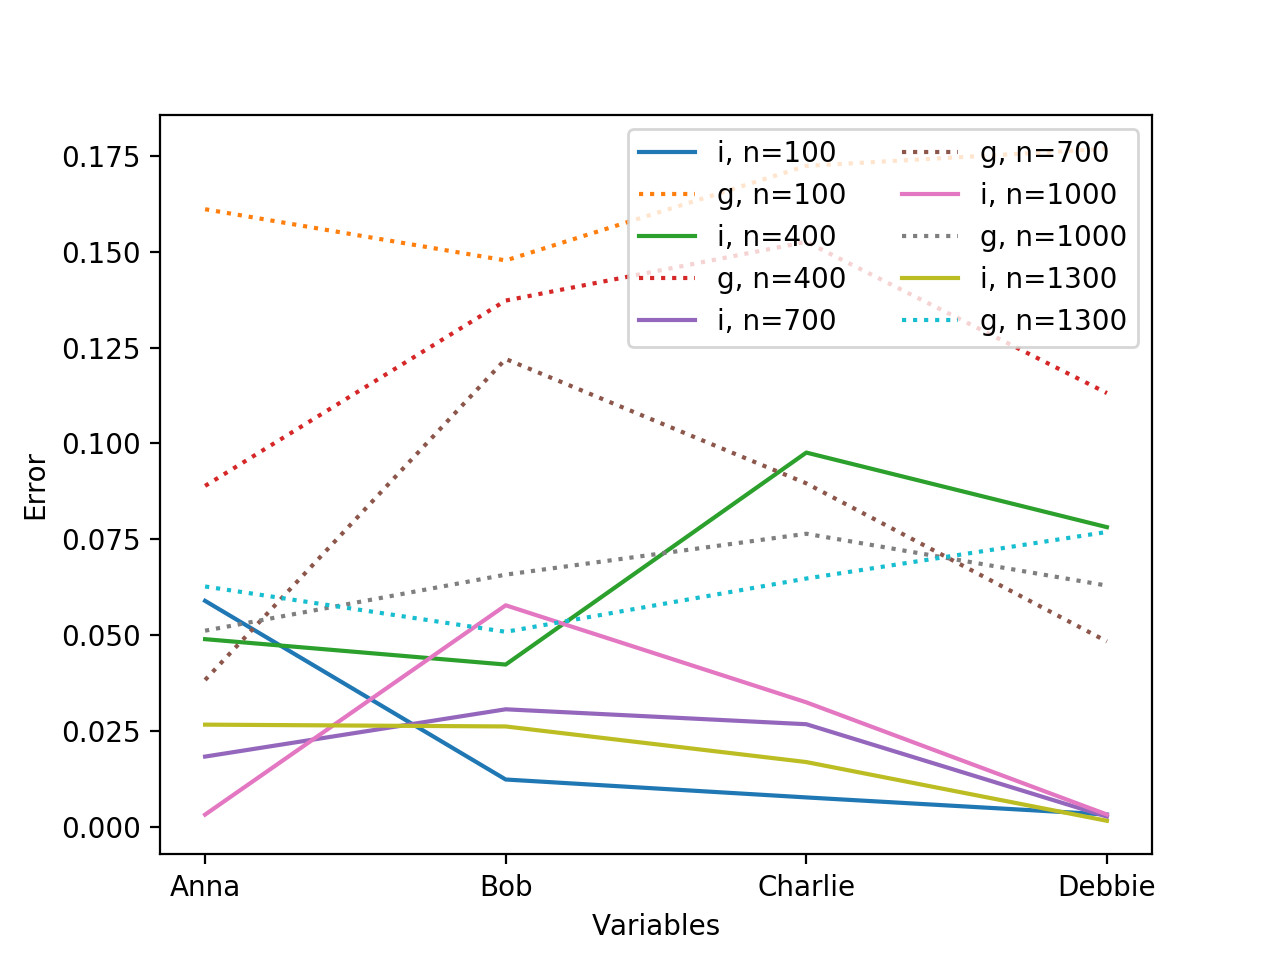

Calculating error for n=100
Calculating error for n=400
Calculating error for n=700
Calculating error for n=1000
Calculating error for n=1300


In [115]:
# Now plot the average L1 estimation error with independent sampling and with Gibbs
# sampling for various choices of n without warmup and without skips.
# YOUR CODE HERE
def plotErr(dist, errors, label='default', linestyle='-'):
    varnames = list(map(lambda x: x.name, dist.vars))
    length = range(len(varnames))
    plt.plot(length, errors, label=label, linestyle=linestyle)
    plt.xticks(length, varnames)
    plt.xlabel('Variables')
    plt.ylabel('Error')
    plt.legend(ncol=2)

nextplot()
for n in range(100, 1600, 300):
    Gtest = Gm.copy()
    print('Calculating error for n={}'.format(n))
    expected = marginals(distm)
    estimated_i = marginals( distm.sample(n).normalize() )
    estimated_g = run_gibbs(Gtest, Gtest.vars, n, marginals=True, normalize=True)

    plotErr(distm, l1(expected, estimated_i), 'i, n=' + str(n))
    plotErr(distm, l1(expected, estimated_g), 'g, n=' + str(n), linestyle=':')

<IPython.core.display.Javascript object>


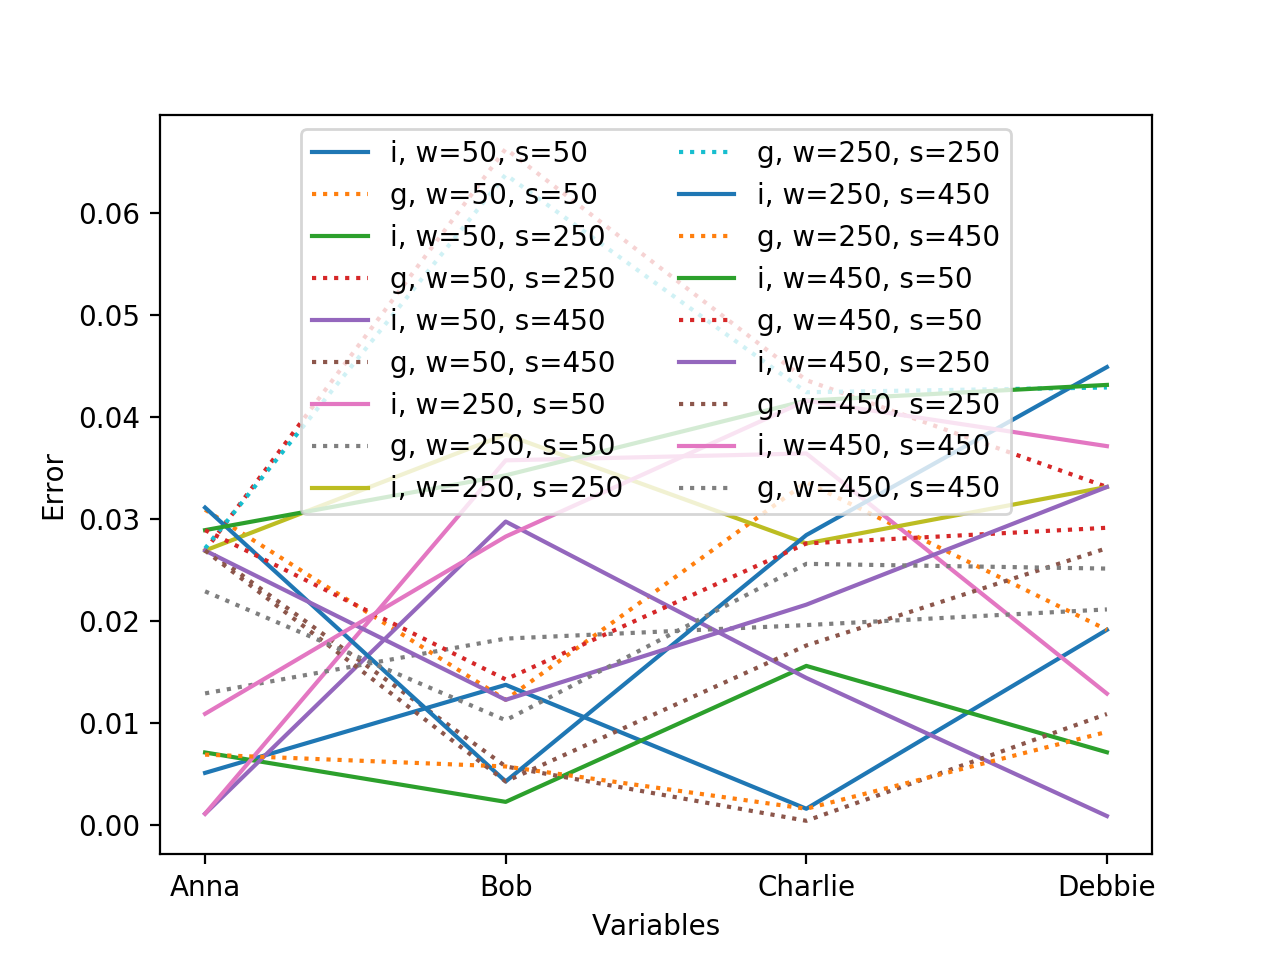

Calculating error for warmup=50 and skip=50
Calculating error for warmup=50 and skip=250
Calculating error for warmup=50 and skip=450
Calculating error for warmup=250 and skip=50
Calculating error for warmup=250 and skip=250
Calculating error for warmup=250 and skip=450
Calculating error for warmup=450 and skip=50
Calculating error for warmup=450 and skip=250
Calculating error for warmup=450 and skip=450


In [132]:
# Now fix the sample size to 1000 and investigate the impact of warmup and skip.
# YOUR CODE HERE
nextplot()
n = 1000
for warmup in range(50, 500, 200):
    for skip in range(50, 500, 200):
        Gtest = Gm.copy()
        print('Calculating error for warmup={} and skip={}'.format(warmup, skip))
        expected = marginals(distm)
        estimated_i = marginals( distm.sample(n).normalize() )
        estimated_g = run_gibbs(Gtest, Gtest.vars, n, marginals=True, normalize=True, warmup=warmup, skip=skip)

        plotErr(distm, l1(expected, estimated_i), 'i, w=' + str(warmup) + ', s=' + str(skip))
        plotErr(distm, l1(expected, estimated_g), 'g, w=' + str(warmup) + ', s=' + str(skip), linestyle=':')

# 2 Factor Graphs and Naive Bayes

In [94]:
# let's load a Naive Bayes model trained for the previous exercise
with open('data/model_nb2.pckl', 'rb') as f:
    model_nb2 = pickle.load(f)

In [95]:
# We can convert the model to a factor graph
G_nb2, Y, Xs = nb_to_factorgraph(model_nb2)

In [96]:
# Exercise 2.a
# Sample P(Y | X) once.

# Crashes my kernel - see solution for a description
# of what should happen
# run_gibbs(G_nb2, [Y], 1, marginals=True)

FactorGraph (785 variables, 785 factors)
Y=0


<IPython.core.display.Javascript object>


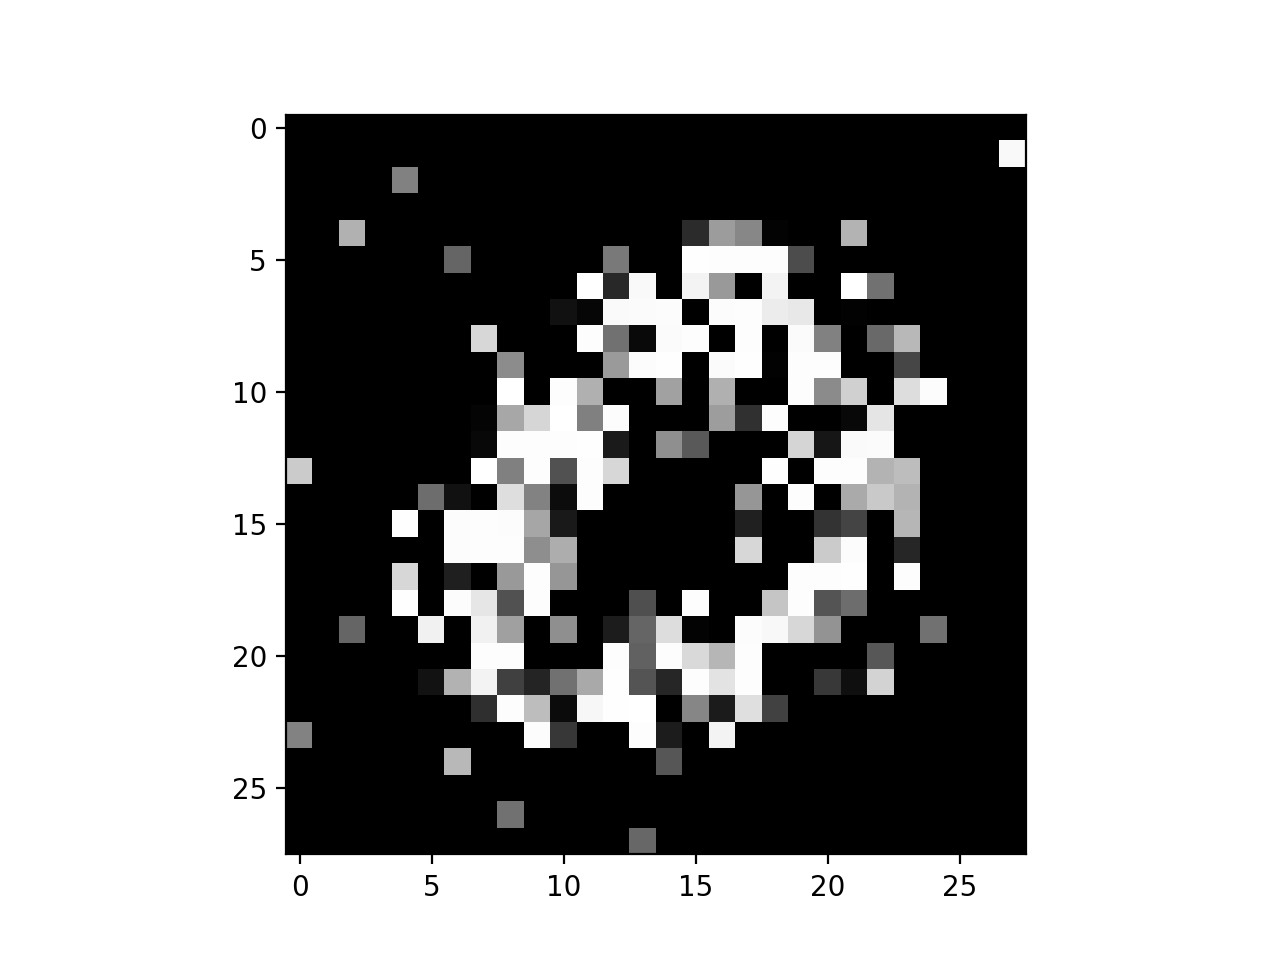

In [97]:
# Exercise 2.c
# Sample P(Y | X) once.
print(G_nb2)
print(Y)

for X in Xs:
    run_gibbs(G_nb2, [X], 1)
    
# plot the image represented by the current variables
nextplot()
showdigit( np.array([ X.value for X in Xs]) )

FactorGraph (785 variables, 785 factors)
Y=0


<IPython.core.display.Javascript object>


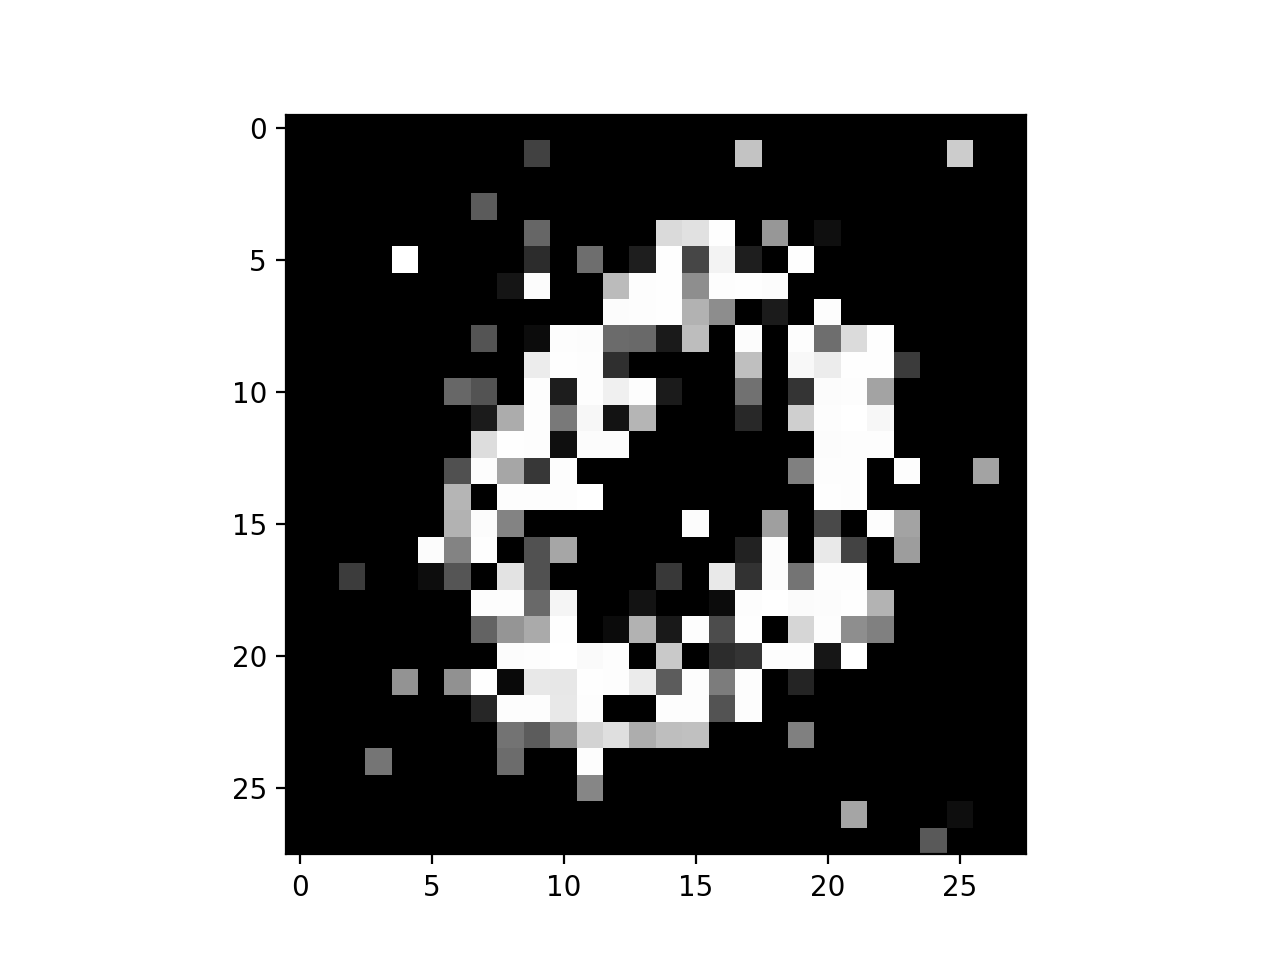

In [98]:
# Exercise 2.d
# Sample P(Y | X) n times.
print(G_nb2)
print(Y)

for X in Xs:
    run_gibbs(G_nb2, [X], 200)

# plot the image represented by the current variables
nextplot()
showdigit( np.array([ X.value for X in Xs]) )

# 3 Conditional Random Fields

In [174]:
# Read in the data.
#
# docs is a list of of documents. Each document is a list of sentences, each
# sentence is a list of (token, label)-pairs. Label is 1 if token is part of
# named entity, else 0.
#
# sentences is a list of all sentences with part-of-speech tags added. Each
# element is a (token, part-of-speech, label)-triple.
#
# Dataset has been created using (if you want, see code in a03-helper.py for
# details):
# docs, sentences = load_reuters()
# pickle.dump((docs,sentences), open('data/reuters.pckl', 'wb'))
with open('data/reuters.pckl', 'rb') as f:
    docs, sentences = pickle.load(f)
print('Number of sentences:', len(sentences))
print('First sentence:', sentences[0])

Number of sentences: 740
First sentence: [('Paxar', 'NNP', 1), ('Corp', 'NNP', 1), ('said', 'VBD', 0), ('it', 'PRP', 0), ('has', 'VBZ', 0), ('acquired', 'VBN', 0), ('Thermo-Print', 'NNP', 1), ('GmbH', 'NNP', 1), ('of', 'IN', 0), ('Lohn', 'NNP', 1), (',', ',', 0), ('West', 'NNP', 1), ('Germany', 'NNP', 1), (',', ',', 0), ('a', 'DT', 0), ('distributor', 'NN', 0), ('of', 'IN', 0), ('Paxar', 'NNP', 1), ('products,', 'NN', 0), ('for', 'IN', 0), ('undisclosed', 'JJ', 0), ('terms', 'NNS', 0)]


In [175]:
# split into input, pos feature, and output sequences
X = [ [ t for t,p,l in sentence ] for sentence in sentences ]
Fpos_tag = [ [ p for t,p,l in sentence ] for sentence in sentences ]
Y = [ [ str(l) for t,p,l in sentence ] for sentence in sentences ]
print('X[0]:', X[0])
print('Fpos_tag[0]:', Fpos_tag[0])
print('Y[0]:', Y[0])

X[0]: ['Paxar', 'Corp', 'said', 'it', 'has', 'acquired', 'Thermo-Print', 'GmbH', 'of', 'Lohn', ',', 'West', 'Germany', ',', 'a', 'distributor', 'of', 'Paxar', 'products,', 'for', 'undisclosed', 'terms']
Fpos_tag[0]: ['NNP', 'NNP', 'VBD', 'PRP', 'VBZ', 'VBN', 'NNP', 'NNP', 'IN', 'NNP', ',', 'NNP', 'NNP', ',', 'DT', 'NN', 'IN', 'NNP', 'NN', 'IN', 'JJ', 'NNS']
Y[0]: ['1', '1', '0', '0', '0', '0', '1', '1', '0', '1', '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0']


In [176]:
# split into training and test set (each containing sentence numbers)
numpy.random.seed(1)
train = list(numpy.random.choice(range(len(X)), size=int(0.8*len(X)), replace=False))
test = [ i for i in range(len(X)) if i not in train ]

## 3a Features

In [177]:
# modify this function to experiment with other features
def get_features(i, j):
    """Return a list of features for the `j`-th output of input sentence `X[i]`.

    Features are binary and represented as a string. All features with the same
    name share the same weight (parameter sharing). This function should return
    the names of the features relevant for (i.e., connected to) the `j`-th
    output `Y[i][j]` of input sentence `X[i]`. These features can be computed
    from the corresponding word `X[i][j]`, but also from arbirary other elements
    of sentence `X[i]`.
    """

    # features for all outputs
    features = [
        'bias',                    # bias feature
        'postag=' + Fpos_tag[i][j] # POS tag of current word feature
    ]

    # features for first word
    if j==0:
        features.extend([
            'start'                # start of sentence bias feature
        ])

    # features for last word
    if j==len(X[i])-1:
        features.extend([
            'end'                  # end of sentence bias feature
        ])

    # features for all but first word
    if j>0:
        features.extend([
            '-1:postag='+Fpos_tag[i][j-1]   # POS tag of previous word feature
        ])

    # features for all but last word
    if j<len(X[i])-1:
        features.extend([
            '+1:postag='+Fpos_tag[i][j+1]   # POS tag of next word feature
        ])

    # all done
    return features

In [178]:
# here are the feature extracted for each word of the first sentence
for j in range(len(X[0])):
    print(X[0][j], ":", get_features(0,j))

Paxar : ['bias', 'postag=NNP', 'start', '+1:postag=NNP']
Corp : ['bias', 'postag=NNP', '-1:postag=NNP', '+1:postag=VBD']
said : ['bias', 'postag=VBD', '-1:postag=NNP', '+1:postag=PRP']
it : ['bias', 'postag=PRP', '-1:postag=VBD', '+1:postag=VBZ']
has : ['bias', 'postag=VBZ', '-1:postag=PRP', '+1:postag=VBN']
acquired : ['bias', 'postag=VBN', '-1:postag=VBZ', '+1:postag=NNP']
Thermo-Print : ['bias', 'postag=NNP', '-1:postag=VBN', '+1:postag=NNP']
GmbH : ['bias', 'postag=NNP', '-1:postag=NNP', '+1:postag=IN']
of : ['bias', 'postag=IN', '-1:postag=NNP', '+1:postag=NNP']
Lohn : ['bias', 'postag=NNP', '-1:postag=IN', '+1:postag=,']
, : ['bias', 'postag=,', '-1:postag=NNP', '+1:postag=NNP']
West : ['bias', 'postag=NNP', '-1:postag=,', '+1:postag=NNP']
Germany : ['bias', 'postag=NNP', '-1:postag=NNP', '+1:postag=,']
, : ['bias', 'postag=,', '-1:postag=NNP', '+1:postag=DT']
a : ['bias', 'postag=DT', '-1:postag=,', '+1:postag=NN']
distributor : ['bias', 'postag=NN', '-1:postag=DT', '+1:postag=I

In [179]:
# let's extract all features
F = [ [ get_features(i,j) for j in range(len(X[i])) ] for i in range(len(X)) ]
print("F[0]:", F[0])

F[0]: [['bias', 'postag=NNP', 'start', '+1:postag=NNP'], ['bias', 'postag=NNP', '-1:postag=NNP', '+1:postag=VBD'], ['bias', 'postag=VBD', '-1:postag=NNP', '+1:postag=PRP'], ['bias', 'postag=PRP', '-1:postag=VBD', '+1:postag=VBZ'], ['bias', 'postag=VBZ', '-1:postag=PRP', '+1:postag=VBN'], ['bias', 'postag=VBN', '-1:postag=VBZ', '+1:postag=NNP'], ['bias', 'postag=NNP', '-1:postag=VBN', '+1:postag=NNP'], ['bias', 'postag=NNP', '-1:postag=NNP', '+1:postag=IN'], ['bias', 'postag=IN', '-1:postag=NNP', '+1:postag=NNP'], ['bias', 'postag=NNP', '-1:postag=IN', '+1:postag=,'], ['bias', 'postag=,', '-1:postag=NNP', '+1:postag=NNP'], ['bias', 'postag=NNP', '-1:postag=,', '+1:postag=NNP'], ['bias', 'postag=NNP', '-1:postag=NNP', '+1:postag=,'], ['bias', 'postag=,', '-1:postag=NNP', '+1:postag=DT'], ['bias', 'postag=DT', '-1:postag=,', '+1:postag=NN'], ['bias', 'postag=NN', '-1:postag=DT', '+1:postag=IN'], ['bias', 'postag=IN', '-1:postag=NN', '+1:postag=NNP'], ['bias', 'postag=NNP', '-1:postag=IN',

In [180]:
# Prepare training and testing data; we use letter F to refer to features
def compute_train_test(F, Y, train, test):
    Xtrain = [ X[i] for i in train]
    Ftrain = [ F[i] for i in train ]
    Ytrain = [ Y[i] for i in train ]
    Xtest = [ X[i] for i in test]
    Ftest = [ F[i] for i in test ]
    Ytest = [ Y[i] for i in test ]
    return Xtrain, Ftrain, Ytrain, Xtest, Ftest, Ytest
Xtrain, Ftrain, Ytrain, Xtest, Ftest, Ytest = compute_train_test(F, Y, train, test)

In [181]:
# Use pycrfsuite to train the CRF. Fitted model is stored in file `name`.
def crf_train(Ftrain, Ytrain, name='model.crfsuite', c1=0.1, c2=0.01, max_iterations=200):
    trainer = pycrfsuite.Trainer(verbose=True)
    trainer.set_params({
        'c1': c1,                         # weight for L1 regularization
        'c2': c2,                         # weight for L2 regularization
        'max_iterations': max_iterations, # number of iterations for training
        'feature.possible_transitions': True # include weights for all possible transitions
    })
    for f,y in zip(Ftrain, Ytrain):
        trainer.append(f,y)
    trainer.train(name)

crf_train(Ftrain, Ytrain)

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 168
Seconds required: 0.022

L-BFGS optimization
c1: 0.100000
c2: 0.010000
num_memories: 6
max_iterations: 200
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

***** Iteration #1 *****
Loss: 3920.155755
Feature norm: 1.000000
Error norm: 2183.093438
Active features: 168
Line search trials: 1
Line search step: 0.000087
Seconds required for this iteration: 0.007

***** Iteration #2 *****
Loss: 3627.667241
Feature norm: 1.004206
Error norm: 2071.791749
Active features: 164
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.005

***** Iteration #3 *****
Loss: 2750.855713
Feature norm: 4.095481
Error norm: 3122.528083
Active features: 145
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteratio

***** Iteration #62 *****
Loss: 914.530584
Feature norm: 16.092661
Error norm: 1.404483
Active features: 142
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.004

***** Iteration #63 *****
Loss: 914.530281
Feature norm: 16.089241
Error norm: 5.798744
Active features: 142
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.004

***** Iteration #64 *****
Loss: 914.523929
Feature norm: 16.089384
Error norm: 1.329030
Active features: 142
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.004

***** Iteration #65 *****
Loss: 914.521727
Feature norm: 16.086492
Error norm: 5.558313
Active features: 142
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.004

***** Iteration #66 *****
Loss: 914.512675
Feature norm: 16.083776
Error norm: 2.893796
Active features: 142
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteratio

***** Iteration #153 *****
Loss: 914.096274
Feature norm: 15.724213
Error norm: 3.180483
Active features: 140
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.008

***** Iteration #154 *****
Loss: 914.093638
Feature norm: 15.722227
Error norm: 5.022685
Active features: 140
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.008

***** Iteration #155 *****
Loss: 914.087697
Feature norm: 15.722376
Error norm: 2.450967
Active features: 140
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.009

***** Iteration #156 *****
Loss: 914.087491
Feature norm: 15.719132
Error norm: 6.133761
Active features: 140
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.008

***** Iteration #157 *****
Loss: 914.079900
Feature norm: 15.718155
Error norm: 2.248028
Active features: 140
Line search trials: 2
Line search step: 0.500000
Seconds required for this ite

In [182]:
# Now use the model to predict
def crf_predict(Ftest, name='model.crfsuite'):
    tagger = pycrfsuite.Tagger()
    tagger.open(name)
    return tagger, [ tagger.tag(f) for f in Ftest ]

tagger, Ypred = crf_predict(Ftest)

In [183]:
# Let's take a look at a a random test sentence
i = numpy.random.choice(len(Xtest))
for j in range(len(Xtest[i])):
    print(Xtest[i][j], ": ", "label=", Ytest[i][j], "; predicted=", Ypred[i][j] )

Makoto :  label= 1 ; predicted= 1
Kuroda :  label= 1 ; predicted= 1
, :  label= 0 ; predicted= 0
vice :  label= 0 ; predicted= 0
minister :  label= 0 ; predicted= 0
of :  label= 0 ; predicted= 0
Japans :  label= 1 ; predicted= 1
Ministry :  label= 1 ; predicted= 1
of :  label= 1 ; predicted= 0
International :  label= 1 ; predicted= 1
Trade :  label= 1 ; predicted= 1
and :  label= 1 ; predicted= 1
Industry :  label= 1 ; predicted= 1
(MITI), :  label= 1 ; predicted= 1
is :  label= 0 ; predicted= 0
to :  label= 0 ; predicted= 0
hold :  label= 0 ; predicted= 0
two :  label= 0 ; predicted= 0
days :  label= 0 ; predicted= 0
of :  label= 0 ; predicted= 0
meetings :  label= 0 ; predicted= 0
with :  label= 0 ; predicted= 0
the :  label= 0 ; predicted= 0
Deputy :  label= 0 ; predicted= 1
U.S. :  label= 1 ; predicted= 1
Trade :  label= 1 ; predicted= 1
Representative :  label= 1 ; predicted= 1
, :  label= 0 ; predicted= 0
Michael :  label= 1 ; predicted= 1
Smith :  label= 1 ; predicted= 1
, :  la

In [184]:
# Evaluate the performance of your model (micro)
truth = np.array([ int(label) for y in Ytest for label in y ])
pred = np.array([ int(label) for y in Ypred for label in y ])
print( classification_report(truth, pred) )

             precision    recall  f1-score   support

          0       0.98      0.97      0.98      2823
          1       0.78      0.86      0.82       314

avg / total       0.96      0.96      0.96      3137



In [185]:
# do everything at once
def crf_train_and_predict(f=get_features, name='model.crfsuite',
                      c1=0.1, c2=0.02, max_iterations=200):
    F = [ [ f(i,j) for j in range(len(X[i])) ] for i in range(len(X)) ]
    Xtrain, Ftrain, Ytrain, Xtest, Ftest, Ytest = compute_train_test(F, Y, train, test)
    crf_train(Ftrain, Ytrain, name, c1, c2, max_iterations)
    return crf_predict(Ftest, name)

tagger, Ypred = crf_train_and_predict(get_features)

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 168
Seconds required: 0.019

L-BFGS optimization
c1: 0.100000
c2: 0.020000
num_memories: 6
max_iterations: 200
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

***** Iteration #1 *****
Loss: 3920.165755
Feature norm: 1.000000
Error norm: 2183.097572
Active features: 168
Line search trials: 1
Line search step: 0.000087
Seconds required for this iteration: 0.007

***** Iteration #2 *****
Loss: 3627.677682
Feature norm: 1.004204
Error norm: 2071.788970
Active features: 164
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.005

***** Iteration #3 *****
Loss: 2750.956982
Feature norm: 4.095228
Error norm: 3122.606799
Active features: 145
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteratio

***** Iteration #61 *****
Loss: 916.851775
Feature norm: 15.082537
Error norm: 3.575387
Active features: 143
Line search trials: 3
Line search step: 0.250000
Seconds required for this iteration: 0.012

***** Iteration #62 *****
Loss: 916.847222
Feature norm: 15.080095
Error norm: 7.355727
Active features: 143
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.008

***** Iteration #63 *****
Loss: 916.835866
Feature norm: 15.078702
Error norm: 7.245816
Active features: 143
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.008

***** Iteration #64 *****
Loss: 916.823844
Feature norm: 15.076466
Error norm: 2.376976
Active features: 143
Line search trials: 3
Line search step: 0.250000
Seconds required for this iteration: 0.012

***** Iteration #65 *****
Loss: 916.823797
Feature norm: 15.074228
Error norm: 8.456591
Active features: 142
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteratio

***** Iteration #154 *****
Loss: 916.284786
Feature norm: 14.739256
Error norm: 2.583052
Active features: 140
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.009

***** Iteration #155 *****
Loss: 916.281521
Feature norm: 14.736268
Error norm: 4.186421
Active features: 140
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.009

***** Iteration #156 *****
Loss: 916.277879
Feature norm: 14.736630
Error norm: 3.101166
Active features: 140
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.008

***** Iteration #157 *****
Loss: 916.275060
Feature norm: 14.735266
Error norm: 5.272415
Active features: 139
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.008

***** Iteration #158 *****
Loss: 916.268970
Feature norm: 14.735902
Error norm: 2.879637
Active features: 139
Line search trials: 2
Line search step: 0.500000
Seconds required for this ite

In [186]:
import re
# Now experiment with your own set of features. Examples:
# - the current word (e.g., in lowercase for normalization)
# - prefix/suffix features for current word (e.g., ends with "ion")
# - whether current word starts capitalized
# - whether current word is a number
# - whether current word contains special characters (e.g., dollar sign)
# - similar features for surrounding words
# - combined features of current and surrounding word
def get_features_improved(i, j):
    # YOUR CODE HERE
    # features for all outputs
    features = get_features(i, j)
        
    def isCapitalized(word):
        return word[0].isupper()
    
    # word is capitalized
    if isCapitalized(X[i][j]):
        features.extend([
            'capitalized'
        ])
        
    # neighbor and self is capitalized
    try:
        if isCapitalized(X[i][j]) and (isCapitalized(X[i][j + 1]) or isCapitalized(X[i][j - 1])):
            features.extend([
                'neighborAndSelfCapitalized'
            ])
    except IndexError:
        pass # noop
    
    # word contains a digit [0, ..., 9]
    if re.search('.*\d.*', X[i][j]):
        features.extend([
            'containsDigits'
        ])
        
    # word contains number [zero, one, ..., nine]
    numbers = ['zero', 'one', 'two', 'three', 'four', 'five',
               'six', 'seven', 'eight', 'nine']
    for number in numbers:
        if number in X[i][j].lower():
            features.extend([
                'containsNumber'
            ])
            break
            
    # contains non-char characters (e.g. $, :, ;)
    if not re.search('^[a-zA-Z]+$', X[i][j]):
        features.extend([
            'specialChars'
        ])
        
    # suffixes
    # https://dictionary.cambridge.org/grammar/british-grammar/word-formation/suffixes
    suffixes = ['ion', 'ful', 'ment', 'age', 'al', 'dom', 
                'ee', 'hood', 'ism', 'ty', 'ness', 'ship']
    for suffix in suffixes:
        if re.search('.*' + suffix + '$', X[i][j].lower()):
            features.extend([
                'nounSuffix'
            ])

    # all done
    return features

In [187]:
# test it
tagger_improved, Ypred_improved = \
    crf_train_and_predict(get_features_improved, 'model_improved.crfsuite')
pred_improved = np.array([ int(label) for y in Ypred_improved for label in y ])
print( classification_report(truth, pred) )
print( classification_report(truth, pred_improved) )

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 179
Seconds required: 0.020

L-BFGS optimization
c1: 0.100000
c2: 0.020000
num_memories: 6
max_iterations: 200
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

***** Iteration #1 *****
Loss: 3802.450986
Feature norm: 1.000000
Error norm: 2946.894747
Active features: 179
Line search trials: 1
Line search step: 0.000087
Seconds required for this iteration: 0.007

***** Iteration #2 *****
Loss: 3225.073726
Feature norm: 1.045326
Error norm: 2635.041375
Active features: 175
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.005

***** Iteration #3 *****
Loss: 2185.732668
Feature norm: 2.801265
Error norm: 2491.733895
Active features: 162
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteratio

***** Iteration #77 *****
Loss: 761.017753
Feature norm: 14.380251
Error norm: 3.569591
Active features: 148
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.005

***** Iteration #78 *****
Loss: 761.016572
Feature norm: 14.381504
Error norm: 6.068095
Active features: 148
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.004

***** Iteration #79 *****
Loss: 761.010273
Feature norm: 14.381139
Error norm: 3.442856
Active features: 148
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.004

***** Iteration #80 *****
Loss: 761.009723
Feature norm: 14.381642
Error norm: 6.221817
Active features: 148
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.004

***** Iteration #81 *****
Loss: 761.002752
Feature norm: 14.381578
Error norm: 3.069717
Active features: 148
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteratio

***** Iteration #134 *****
Loss: 760.765342
Feature norm: 14.297569
Error norm: 5.366556
Active features: 152
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.010

***** Iteration #135 *****
Loss: 760.759000
Feature norm: 14.291134
Error norm: 3.267248
Active features: 152
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.009

***** Iteration #136 *****
Loss: 760.755836
Feature norm: 14.282178
Error norm: 5.240024
Active features: 152
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.009

***** Iteration #137 *****
Loss: 760.750014
Feature norm: 14.280696
Error norm: 2.609346
Active features: 152
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.009

***** Iteration #138 *****
Loss: 760.745604
Feature norm: 14.273902
Error norm: 3.799429
Active features: 152
Line search trials: 2
Line search step: 0.500000
Seconds required for this ite

## 3b Feature inspection

In [191]:
# inspect weights of transition features (between Y[i-1] and Y[i])
info = tagger_improved.info() # using tagger_improved to include new features
transition_f = np.array([ [ l_from, l_to, info.transitions[(str(l_from),str(l_to))] ] \
                          for l_to in range(2) for l_from in range(2) ])
print( tabulate(transition_f, ["from", "to", "weight"]) )

  from    to     weight
------  ----  ---------
     0     0   1.22809
     1     0  -2.23531
     0     1  -1.72049
     1     1   0.274238


In [192]:
# inspect weights of state features (for Y[i])
state_f = np.array([ [ fl[0], fl[1], w ] \
                      for fl, w in info.state_features.items() ])
print( tabulate(state_f, ["feature", "label", "weight"]) )

feature                       label     weight
--------------------------  -------  ---------
bias                              0   0.994928
bias                              1  -0.994928
postag=NNP                        0  -1.91967
postag=NNP                        1   1.91967
start                             0   1.51446
start                             1  -1.51446
+1:postag=NN                      0   0.350759
+1:postag=NN                      1  -0.350759
capitalized                       0  -2.45379
capitalized                       1   2.45379
specialChars                      0   0.767593
specialChars                      1  -0.767593
postag=NN                         0  -1.18162
postag=NN                         1   1.18162
-1:postag=NNP                     0   0.992632
-1:postag=NNP                     1  -0.992632
+1:postag=VBZ                     0  -0.514331
+1:postag=VBZ                     1   0.514331
nounSuffix                        0  -0.16124
nounSuffix            

In [194]:
# only highest weighted features
state_f_sorted = np.array(sorted(state_f, reverse=True,
                                 key=lambda r: abs(float(r[2]))))
print( tabulate(state_f_sorted[:30,:], ["feature", "label", "weight"]) )

feature           label    weight
--------------  -------  --------
+1:postag=,           1   6.70205
-1:postag=(           1   4.19538
containsDigits        0   3.38014
postag=PRP            0   3.26991
postag=VBD            0   3.01163
capitalized           0  -2.45379
capitalized           1   2.45379
+1:postag=JJS         0   2.41099
postag=,              0   2.27565
-1:postag=)           0   2.13726
postag=NNP            0  -1.91967
postag=NNP            1   1.91967
postag=RB             0   1.5898
postag=VBZ            0   1.54596
end                   0   1.52643
end                   1  -1.52643
start                 0   1.51446
start                 1  -1.51446
postag=NNPS           0  -1.49735
postag=NNPS           1   1.49735
+1:postag=CD          0   1.43664
+1:postag=CD          1  -1.43664
postag=VBP            0  -1.24682
postag=VBP            1   1.24682
+1:postag=EX          0   1.2072
postag=NN             0  -1.18162
postag=NN             1   1.18162
+1:postag=NNP   

## (Optional) 3c/3d CRF to factor graph

In [195]:
# convert a CRF model to a factor graph (for a single test example)
i = 1 ## CRF should make an error on this test example
info = tagger.info()
G = crf_to_factorgraph(Ftest[i], info)
print(G.names())
print(G)

['Y000', 'Y001', 'Y002', 'Y003', 'Y004', 'Y005', 'Y006', 'Y007', 'Y008', 'Y009', 'Y010', 'Y011', 'Y012', 'Y013', 'Y014', 'Y015']
FactorGraph (16 variables, 79 factors)


In [196]:
# print true labels, predicted labels, and sampled labels
print("Sentence:")
print(Xtest[i])
print("Truth:")
print([ int(label) for label in Ytest[i] ])
print("Predicted (MAP estimate by pycrfsuite):")
print([ int(label) for label in Ypred[i] ])
nsamples = 20
print("Sampled (from factor graph of CRF):")
for s in range(nsamples):
    marginals = run_gibbs(G, G.vars, 1000, marginals=True)
    print( G.values(), "weight: {:28.0f}".format(G.value()) )

Sentence:
['Digital', 'Communications', 'Associates', 'Inc', 'said', 'its', 'board', 'has', 'named', 'James', 'Ottinger', 'president', 'and', 'chief', 'operating', 'officer']
Truth:
[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]
Predicted (MAP estimate by pycrfsuite):
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Sampled (from factor graph of CRF):
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] weight:                 104082636260
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] weight:                 104082636260
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] weight:                 104082636260
[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0] weight:                  48074753452
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] weight:                 104082636260
[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0] weight:                  48074753452
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] weight:                 104082636260
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [197]:
# convert impoved CRF model to a factor graph (for a single test example)
i = 1
F_improved = [ [ get_features_improved(i,j)
                 for j in range(len(X[i])) ] for i in range(len(X)) ]
info_improved = tagger_improved.info()
G_improved = crf_to_factorgraph(F_improved[test[i]], info_improved)
print(G_improved.names())
print(G_improved)

['Y000', 'Y001', 'Y002', 'Y003', 'Y004', 'Y005', 'Y006', 'Y007', 'Y008', 'Y009', 'Y010', 'Y011', 'Y012', 'Y013', 'Y014', 'Y015']
FactorGraph (16 variables, 92 factors)


In [198]:
# print true labels, predicted labels, and sampled labels for improved model
print("Sentence:")
print(Xtest[i])
print("Truth:")
print([ int(label) for label in Ytest[i] ])
print("Predicted (MAP estimate by pycrfsuite):")
print([ int(label) for label in Ypred_improved[i] ])
nsamples = 20
print("Sampled (from factor graph of CRF):")
for s in range(nsamples):
    marginals = run_gibbs(G_improved, G_improved.vars, 1000, marginals=True)
    print( G_improved.values(), "weight: {:28.0f}".format(G_improved.value()) )

Sentence:
['Digital', 'Communications', 'Associates', 'Inc', 'said', 'its', 'board', 'has', 'named', 'James', 'Ottinger', 'president', 'and', 'chief', 'operating', 'officer']
Truth:
[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]
Predicted (MAP estimate by pycrfsuite):
[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]
Sampled (from factor graph of CRF):
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] weight:               12230843096433
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] weight:               12230843096433
[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0] weight:               16575088643329
[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0] weight:               16575088643329
[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0] weight:               16575088643329
[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0] weight:               16575088643329
[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0] weight:               16575088643329
[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,